In [9]:
# Perform Google Colab installs (if running in Google Colab)
import os

if "COLAB_GPU" in os.environ:
    print("[INFO] Running in Google Colab, installing requirements.")
    !pip install -U torch # requires torch 2.1.1+ (for efficient sdpa implementation)
    !pip install PyMuPDF # for reading PDFs with Python
    !pip install tqdm # for progress bars
    !pip install sentence-transformers # for embedding models
    !pip install accelerate # for quantization model loading
    !pip install bitsandbytes # for quantizing models (less storage space)
    !pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference
    # Download PDF file
import os
import requests

[INFO] Running in Google Colab, installing requirements.


In [10]:
pdf_path = "./Histoire-de-France-Jacques-Bainville.pdf"

# Download PDF if it doesn't already exist
if not os.path.exists(pdf_path):
  print("File doesn't exist, downloading...")

  # The URL of the PDF you want to download
  url = "https://maurras.net/pdf/divers/Histoire-de-France-Jacques-Bainville.pdf"

  # The local filename to save the downloaded file
  filename = pdf_path

  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Open a file in binary write mode and save the content to it
      with open(filename, "wb") as file:
          file.write(response.content)
      print(f"The file has been downloaded and saved as {filename}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {pdf_path} exists.")
  # Requires !pip install PyMuPDF, see: https://github.com/pymupdf/pymupdf
#import fitz # (pymupdf, found this is better than pypdf for our use case, note: licence is AGPL-3.0, keep that in mind if you want to use any code commercially)
import fitz
from tqdm.auto import tqdm # for progress bars, requires !pip install tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip() # note: this might be different for each doc (best to experiment)

    # Other potential text formatting functions can go here
    return cleaned_text

# Open PDF and get lines/pages
# Note: this only focuses on text, rather than images/figures etc
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.

    Returns:
        list[dict]: A list of dictionaries, each containing the page number
        (adjusted), character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    doc = fitz.open(pdf_path)  # open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):  # iterate the document pages
        text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(text)
        pages_and_texts.append({
                                #"page_number": page_number - 41,  # adjust page numbers since our PDF starts on page 42
                                "page_number": page_number - 4,  # adjust page numbers since our PDF starts on page 42
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars, see: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

File ./Histoire-de-France-Jacques-Bainville.pdf exists.


0it [00:00, ?it/s]

[{'page_number': -4,
  'page_char_count': 36,
  'page_word_count': 5,
  'page_sentence_count_raw': 1,
  'page_token_count': 9.0,
  'text': 'HISTOIRE DE FRANCE Jacques Bainville'},
 {'page_number': -3,
  'page_char_count': 59,
  'page_word_count': 8,
  'page_sentence_count_raw': 1,
  'page_token_count': 14.75,
  'text': '´Editions ´electroniques Indiens & Forˆets et Vexilla Regis'}]

In [11]:
import random

random.sample(pages_and_texts, k=3)
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-4,36,5,1,9.00,HISTOIRE DE FRANCE Jacques Bainville
1,-3,59,8,1,14.75,´Editions ´electroniques Indiens & Forˆets et ...
2,-2,2527,413,19,631.75,Avant-Propos Si les lecteurs veulent bien le l...
3,-1,3328,554,28,832.00,nous sommes amen´e `a nous dire que le peuple ...
4,0,1386,231,16,346.50,"M. Thureau-Dangin est essentielle, comme celle..."


In [12]:
from spacy.lang.fr import French # see https://spacy.io/usage for install instructions

nlp = French()

# Add a sentencizer pipeline, see https://spacy.io/api/sentencizer/
nlp.add_pipe("sentencizer")

# Create a document instance as an example
doc = nlp("This is a sentence. This another sentence.")
assert len(list(doc.sents)) == 2

# Access the sentences of the document
list(doc.sents)


[This is a sentence., This another sentence.]

In [13]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # Count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/340 [00:00<?, ?it/s]

In [14]:
import random

# Inspect an example
random.sample(pages_and_texts, k=1)

[{'page_number': 21,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': '',
  'sentences': [],
  'page_sentence_count_spacy': 0}]

In [15]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,340.00,340.00,340.00,340.00,340.00,340.00
mean,165.50,3023.17,476.08,24.41,755.79,24.79
std,98.29,828.56,129.62,7.65,207.14,8.05
min,-4.00,0.00,1.00,1.00,0.00,0.00
25%,80.75,3267.75,507.00,21.00,816.94,21.00
50%,165.50,3340.00,522.00,25.00,835.00,26.00
75%,250.25,3389.00,536.00,29.00,847.25,30.00
max,335.00,3496.00,563.00,40.00,874.00,43.00


In [16]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list,
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/340 [00:00<?, ?it/s]

In [17]:
# Sample an example from the group (note: many samples have only 1 chunk as they have <=10 sentences total)
random.sample(pages_and_texts, k=1)

[{'page_number': 262,
  'page_char_count': 2979,
  'page_word_count': 463,
  'page_sentence_count_raw': 23,
  'page_token_count': 744.75,
  'text': 'de guerre, qui nous a paru si naturelle, faisait, en 1830, crier `a un attentat contre la libert´e. Le roi et son ministre, par une ´etrange imprudence, ne tinrent aucun compte de l’agitation qui commen¸cait `a Paris. Charles X ´etait convaincu de n’avoir aﬀaire qu’`a une r´esistance l´egale, comme lui-mˆeme, appuy´e sur l’article 14, ´etait dans la l´egalit´e. Le jour o`u l’´emeute ´eclata, il partit tran- quillement pour la chasse. Aucune pr´ecaution n’avait ´et´e prise. Le ministre de la guerre ´etait aux eaux. La garnison de Paris ´etait r´eduite `a 14 000 hommes, des troupes ayant ´et´e pr´elev´ees pour la campagne d’Alger. Des r´egiments sˆurs ´etaient `a Saint-Omer `a cause des aﬀaires de Belgique ou dans d’autres villes de province pour des c´er´emonies. Les 27, 28, 29 juillet, les insurg´es, venus des faubourgs et du quartier des 

In [18]:
# Create a DataFrame to get stats
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,340.00,340.00,340.00,340.00,340.00,340.00,340.00
mean,165.50,3023.17,476.08,24.41,755.79,24.79,2.92
std,98.29,828.56,129.62,7.65,207.14,8.05,0.89
min,-4.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,80.75,3267.75,507.00,21.00,816.94,21.00,3.00
50%,165.50,3340.00,522.00,25.00,835.00,26.00,3.00
75%,250.25,3389.00,536.00,29.00,847.25,30.00,3.00
max,335.00,3496.00,563.00,40.00,874.00,43.00,5.00


In [19]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters

        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

  0%|          | 0/340 [00:00<?, ?it/s]

993

In [20]:
# View a random sample
random.sample(pages_and_chunks, k=1)

[{'page_number': 251,
  'sentence_chunk': 'Les Alli´es avaient feint de la combattre au nom d’un principe. Elle s’armait maintenant de ce principe pour empˆecher les dangereux accroissements des autres pays, les vastes agglom´erations que Napol´eon n’avait que trop favo- ris´ees. Elle s’en armait pour mettre l’Allemagne `a l’abri de la Prusse, l’Italie `a l’abri de l’Autriche, la Turquie enﬁn, o`u nous avions `a maintenir nos anciens privil`eges, `a l’abri de la Russie. Cette politique, conforme `a nos meilleures traditions diplomatiques, renouait avec celle de Vergennes. C’´etait celle de notre s´ecurit´e. Elle nous mettait `a la tˆete du parti de la mod´eration, nous rendait le rˆole de protecteurs des ´Etats moyens et petits. C’est dans cet esprit que Talleyrand d´efendit le roi de Saxe qui ´etait rest´e ﬁd`ele `a Napol´eon, et dont la Prusse, sous ce pr´etexte, voulait garder le royaume. L’ind´ependance de la Saxe garantissait l’ind´ependance des autres ´Etats germaniques et, dans 

In [21]:
# Get stats about our chunks
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,993.00,993.00,993.00,993.00
mean,159.72,1033.92,162.46,258.48
std,97.20,448.68,69.68,112.17
min,-4.00,2.00,1.00,0.50
25%,73.00,802.00,126.00,200.50
50%,158.00,1080.00,168.00,270.00
75%,243.00,1333.00,208.00,333.25
max,335.00,2482.00,377.00,620.50


In [22]:
# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(10, replace=True).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 22.0 | Text: Les batailles qui s’engag`erent l`a et qui dur`erent pr`es de six mois ont ´et´e les 328
Chunk token count: 0.75 | Text: 269
Chunk token count: 21.5 | Text: Selon la tradition r´evolutionnaire, le Directoire s’´etait « ´epur´e » lui-mˆeme, 230
Chunk token count: 0.75 | Text: 228
Chunk token count: 21.5 | Text: Selon la tradition r´evolutionnaire, le Directoire s’´etait « ´epur´e » lui-mˆeme, 230
Chunk token count: 18.75 | Text: Il ne s’est pas fait sans peine. Il s’est fait de main d’homme. Plusieurs 7
Chunk token count: 0.75 | Text: 243
Chunk token count: 10.5 | Text: Orl´eans ´etablissait des taxes : elles 64
Chunk token count: 21.5 | Text: Selon la tradition r´evolutionnaire, le Directoire s’´etait « ´epur´e » lui-mˆeme, 230
Chunk token count: 20.75 | Text: Nous ne sommes pas assez habitu´es `a penser au temps et au concours de circons- 29


In [23]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -2,
  'sentence_chunk': 'Avant-Propos Si les lecteurs veulent bien le lui permettre, l’auteur de ce livre commen- cera par une confession. Quand il ´etait au coll`ege, il n’aimait pas beaucoup l’histoire. Elle lui inspirait de l’ennui. Et quand le goˆut lui en est venu plus tard, il s’est rendu compte d’une chose : c’est qu’il r´epugnait `a la narration des faits align´es, les uns au bout des autres. On ne lui avait jamais dit, ou bien on ne lui avait dit que d’une mani`ere convenue et insuﬃsante, pourquoi les peuples faisaient des guerres et des r´evolutions, pourquoi les hommes se battaient, se tuaient, se r´econciliaient. L’histoire ´etait un tissu de drames sans suite, une mˆel´ee, un chaos o`u l’intelligence ne discernait rien. Est-il vrai qu’il faille enseigner l’histoire aux enfants sans qu’ils la com- prennent et de fa¸con `a meubler leur m´emoire de quelques dates et de quelques ´ev´enements ?C’est extrˆemement douteux. On ne s’y prendrait pas autrement si l’o

In [1]:
pip install --upgrade sentence-transformers transformers


In [2]:
from sentence_transformers import SentenceTransformer


In [3]:
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device="cpu") # choose the device to load the model to (note: GPU will often be *much* faster than CPU)

# Create a list of sentences to turn into numbers
sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

# Sentences are encoded/embedded by calling model.encode(),
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-2.07981113e-02  3.03165037e-02 -2.01217793e-02  6.86483830e-02
 -2.55255643e-02 -8.47689249e-03 -2.07147663e-04 -6.32377118e-02
  2.81606149e-02 -3.33353840e-02  3.02634649e-02  5.30720763e-02
 -5.03526479e-02  2.62288153e-02  3.33314016e-02 -4.51578461e-02
  3.63043845e-02 -1.37116178e-03 -1.20171569e-02  1.14946812e-02
  5.04510887e-02  4.70857173e-02  2.11912915e-02  5.14607765e-02
 -2.03746371e-02 -3.58889103e-02 -6.67888962e-04 -2.94393133e-02
  4.95858490e-02 -1.05639603e-02 -1.52013749e-02 -1.31754903e-03
  4.48196754e-02  1.56023391e-02  8.60379942e-07 -1.21397164e-03
 -2.37978995e-02 -9.09372000e-04  7.34479493e-03 -2.53932923e-03
  5.23370057e-02 -4.68043573e-02  1.66214500e-02  4.71579209e-02
 -4.15599570e-02  9.01942665e-04  3.60278897e-02  3.42214778e-02
  9.68227163e-02  5.94828576e-02 -1.64984670e-02 -3.51250097e-02
  5.92516316e-03 -7.07960629e-04 -2.4103

In [4]:
single_sentence = "Yo! How cool are embeddings?"
single_embedding = embedding_model.encode(single_sentence)
print(f"Sentence: {single_sentence}")
print(f"Embedding:\n{single_embedding}")
print(f"Embedding size: {single_embedding.shape}")

Sentence: Yo! How cool are embeddings?
Embedding:
[-1.97447427e-02 -4.51086881e-03 -4.98485053e-03  6.55445009e-02
 -9.87679232e-03  2.72835400e-02  3.66426297e-02 -3.30218766e-03
  8.50079488e-03  8.24953429e-03 -2.28496902e-02  4.02430221e-02
 -5.75200692e-02  6.33693114e-02  4.43207026e-02 -4.49507199e-02
  1.25284074e-02 -2.52012592e-02 -3.55292559e-02  1.29559208e-02
  8.67017172e-03 -1.92917418e-02  3.55633581e-03  1.89505871e-02
 -1.47128394e-02 -9.39850323e-03  7.64166377e-03  9.62190889e-03
 -5.98926842e-03 -3.90170179e-02 -5.47824502e-02 -5.67451864e-03
  1.11644585e-02  4.08067852e-02  1.76319122e-06  9.15295724e-03
 -8.77268612e-03  2.39383057e-02 -2.32784506e-02  8.04999471e-02
  3.19177508e-02  5.12592029e-03 -1.47708794e-02 -1.62525047e-02
 -6.03212789e-02 -4.35689688e-02  4.51210849e-02 -1.79053862e-02
  2.63366923e-02 -3.47867236e-02 -8.89174361e-03 -5.47675230e-02
 -1.24372840e-02 -2.38606390e-02  8.33497047e-02  5.71242571e-02
  1.13328639e-02 -1.49595207e-02  9.2037

In [25]:
%%time
from tqdm import tqdm
# Uncomment to see how long it takes to create embeddings on CPU
# Make sure the model is on the CPU
embedding_model.to("cpu")

# Embed each chunk one by one
for item in tqdm(pages_and_chunks_over_min_token_len):
     item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  1%|          | 5/953 [00:08<26:05,  1.65s/it]


KeyboardInterrupt: 

In [26]:
%%time

# Send the model to the GPU
embedding_model.to("cuda") # requires a GPU installed, for reference on my local machine, I'm using a NVIDIA RTX 4090

# Create embeddings one by one on the GPU
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

100%|██████████| 953/953 [00:31<00:00, 29.88it/s]

CPU times: user 26.6 s, sys: 519 ms, total: 27.1 s
Wall time: 32.2 s


In [27]:
# Turn text chunks into a single list
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

In [28]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=8, # you can use different batch sizes here for speed/performance, I found 32 works well for this use case
                                               convert_to_tensor=True) # optional to return embeddings as tensor instead of array

text_chunk_embeddings

CPU times: user 20.8 s, sys: 66.2 ms, total: 20.9 s
Wall time: 20.4 s


tensor([[ 0.0101,  0.0453, -0.0141,  ...,  0.0641,  0.0087, -0.0349],
        [ 0.0230,  0.0510,  0.0118,  ...,  0.0530,  0.0123, -0.0316],
        [-0.0147,  0.0588,  0.0188,  ...,  0.0386,  0.0173, -0.0139],
        ...,
        [-0.0062,  0.0014,  0.0006,  ...,  0.0326,  0.0280,  0.0184],
        [ 0.0333,  0.0734,  0.0245,  ..., -0.0135,  0.0016, -0.0103],
        [ 0.0230,  0.0781,  0.0190,  ...,  0.0004,  0.0054, -0.0079]],
       device='cuda:0')

In [29]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.tail()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
948,331,du Rhin tant que l’Allemagne n’aurait pas remp...,1317,214,329.25,[ 2.08747648e-02 2.17165041e-04 2.04146709e-...
949,331,Elle a d´ej`a exig´e des capitaux consid´erabl...,1884,295,471.00,[ 2.90157255e-02 2.14769673e-02 2.26470325e-...
950,332,"des choses qui semblent naturelles, tandis que...",1100,181,275.00,[-6.22086646e-03 1.37366063e-03 6.22913765e-...
951,334,Table des mati`eres Avant-Propos 3 1 Pendant c...,886,164,221.50,[ 3.33189964e-02 7.34058991e-02 2.44596377e-...
952,335,16 La R´evolution 199 17 Le Consulat et l’Empi...,249,47,62.25,[ 2.30389200e-02 7.80863315e-02 1.90328434e-...


In [30]:
import random

import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape
type(embeddings)
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-2,Avant-Propos Si les lecteurs veulent bien le l...,1210,197,302.50,"[0.0100920228, 0.0453120656, -0.0140629662, 0...."
1,-2,On cherche alors la raison de tout ce qu’ils o...,1255,204,313.75,"[0.0229921229, 0.0510064512, 0.0117522981, 0.0..."
2,-1,nous sommes amen´e `a nous dire que le peuple ...,887,146,221.75,"[-0.014711, 0.0588025451, 0.0187765993, 0.0010..."
3,-1,"S’il n’abr´egeait pas, — et la remarque n’est ...",1555,253,388.75,"[0.0305562317, 0.0436450727, 0.0287145767, 0.0..."
4,-1,Ses Lundis et ses Nouveaux Lundis sont remplis...,881,152,220.25,"[0.0094827665, 0.00161307957, 0.0191220772, 0...."


In [32]:
embeddings[0]

tensor([ 1.0092e-02,  4.5312e-02, -1.4063e-02,  3.5220e-02, -1.9641e-02,
         2.3350e-02,  7.6350e-03,  4.9022e-02, -1.6058e-03, -6.0598e-02,
        -2.8631e-02,  1.5138e-02,  3.8896e-02, -3.7584e-02, -2.5495e-02,
         5.8302e-02, -1.4902e-02,  1.0872e-02, -4.2996e-02,  5.1967e-03,
         2.6106e-04,  4.4812e-02, -2.2779e-03, -3.7857e-02,  4.3432e-02,
         3.3047e-03, -1.8239e-02,  9.5817e-04, -1.5512e-02, -3.1081e-04,
        -2.4551e-02,  2.9883e-02,  3.4341e-03,  1.0975e-02,  2.7799e-06,
         5.0328e-06, -3.4865e-02, -6.0737e-02, -2.6508e-02, -1.2114e-04,
        -1.3946e-02,  4.8998e-02,  1.3236e-02, -4.2715e-02,  5.5566e-03,
        -3.0696e-04, -2.3654e-02,  2.0633e-03, -2.1938e-02,  9.7632e-03,
         2.6628e-02, -1.2040e-02,  8.4234e-02, -3.1399e-03,  1.2353e-02,
         4.5312e-02,  1.8657e-02, -7.3216e-02,  1.8730e-03, -3.4071e-02,
         1.8437e-02,  2.2073e-02,  8.5606e-03, -3.0141e-02, -1.1311e-01,
        -4.5899e-02,  2.2046e-02, -2.1439e-02,  1.1

In [33]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device) # choose the device to load the model to

In [34]:
# 1. Define the query
# Note: This could be anything. But since we're working with a nutrition textbook, we'll stick with nutrition-based queries.
#query = "macronutrients functions"
query = "token filter"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product (we'll time this for fun)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: token filter
Time taken to get scores on 953 embeddings: 0.00040 seconds.


torch.return_types.topk(
values=tensor([0.1130, 0.1084, 0.1018, 0.1011, 0.0981], device='cuda:0'),
indices=tensor([529, 945, 256, 568, 226], device='cuda:0'))

In [35]:
larger_embeddings = torch.randn(1000*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([953000, 768])
Time take to get scores on 953000 embeddings: 0.02178 seconds.


In [36]:
# Define helper function to print wrapped text
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [37]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'token filter'

Results:
Score: 0.1130
Text:
supprimer les exemptions et les privil`eges, et ces projets soulevaient tou-
jours les mˆemes tempˆetes. D’autre part, Turgot, convaincu comme l’avait ´et´e
Sully, que l’agriculture ´etait la base de la richesse nationale, cherchait `a
la favoriser de diverses mani`eres et en mˆeme temps `a rem´edier au ﬂ´eau des
disettes par la libert´e du commerce des bl´es. L`a, il ne se heurta pas seule-
ment aux int´erˆets, mais aux pr´ejug´es. Il fut accus´e, lui, l’honnˆete homme,
de faire sortir le grain du royaume comme Louis XV l’avait ´et´e du « pacte de
famine ». Dans son programme de libert´e, Turgot touchait d’ailleurs `a d’autres
privil`eges, ceux des corporations de m´etiers, ce qui provoquait les col`eres
du petit commerce. Ses pr´ef´erences pour l’agriculture lui valaient aussi le
ressentiment de l’industrie et de la ﬁnance. «Turgot, dit Michelet, eut contre
lui les seigneurs et les ´epiciers. »Il faut ajouter les banquiers dont le
p

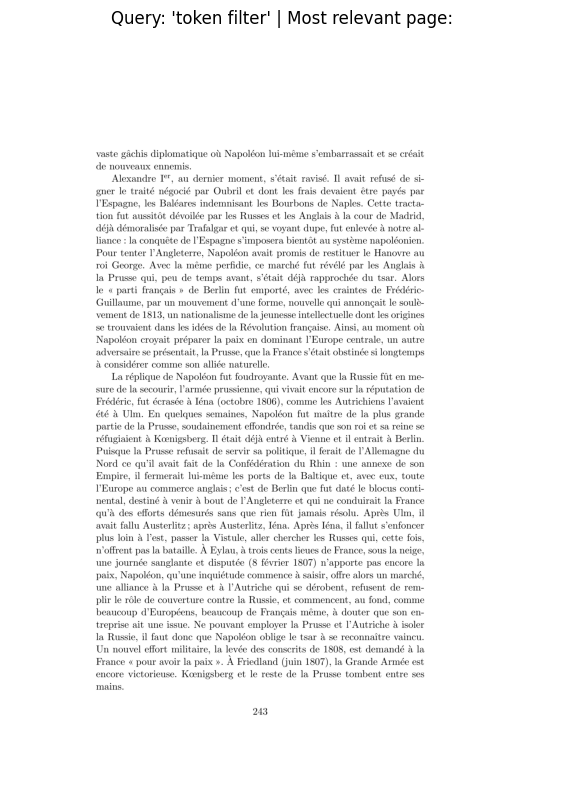

In [39]:
import fitz

# Open PDF and load target page
# pdf_path = "human-nutrition-text.pdf" # requires PDF to be downloaded
pdf_path = "Histoire-de-France-Jacques-Bainville.pdf"
doc = fitz.open(pdf_path)
#page = doc.load_page(5 + 41) # number of page (our doc starts page numbers on page 41)
page = doc.load_page(238 + 4)

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()

In [40]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm of each vector (removes the magnitude, keeps direction)
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

# Example tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Calculate cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


In [41]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query,
                                   convert_to_tensor=True)

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """

    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)

    print(f"Query: {query}\n")
    print("Results:")
        # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [42]:
# query = "symptoms of pellagra"
query = "SolrCloud"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 953 embeddings: 0.00006 seconds.


(tensor([0.1232, 0.1165, 0.1150, 0.1067, 0.1064], device='cuda:0'),
 tensor([480, 544, 201, 869, 518], device='cuda:0'))

In [43]:
# Print out the texts of the top scores
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 953 embeddings: 0.00006 seconds.
Query: SolrCloud

Results:
Score: 0.1232
Depuis le jour o`u l’´electeur de Brandebourg avait pris le titre de roi, la
Prusse avait grandi dans le silence. Fr´ed´eric-Guillaume, le Roi-Sergent, avait
constitu´e `a force d’application, d’organisation et d’´economie un ´Etat et une
arm´ee solides. Son ﬁls Fr´ed´eric II, qui venait de lui succ´eder, avait donn´e
le change sur ses ambitions par une jeunesse orageuse, l’´etalage de ses goˆuts
pour notre litt´erature et le soin qu’il avait pris de conqu´erir une v´eritable
163
Page number: 158


Score: 0.1165
La Fayette en ´etait, ainsi que de grands seigneurs renomm´es pour leur « phil-
anthropie » et leur attachement aux id´ees nouvelles. Dans les secr´etariats,
187
Page number: 182


Score: 0.1150
Henri V s’empressa de prendre possession de la Bastille, du Louvre et de
Vincennes. De ces forteresses, un roi ´etranger 67
Page number: 62


Score: 0.1067
Comme Louis XVIII, le 

GET LLM

In [44]:
from huggingface_hub import login
login()

In [45]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

use_quantization_config = True

# 1. Create quantization config for smaller model loading (optional)
# Requires !pip install bitsandbytes accelerate, see: https://github.com/TimDettmers/bitsandbytes, https://huggingface.co/docs/accelerate/
# For models that require 4-bit quantization (use this if you have low GPU memory available)
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

# Bonus: Setup Flash Attention 2 for faster inference, default to "sdpa" or "scaled dot product attention" if it's not available
# Flash Attention 2 requires NVIDIA GPU compute capability of 8.0 or above, see: https://developer.nvidia.com/cuda-gpus
# Requires !pip install flash-attn, see: https://github.com/Dao-AILab/flash-attention
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

# 2. Pick a model we'd like to use (this will depend on how much GPU memory you have available)
#model_id = "google/gemma-7b-it"
model_id = "google/gemma-2b-it" # (we already set this above)
print(f"[INFO] Using model_id: {model_id}")

# 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)



[INFO] Using attention implementation: sdpa
[INFO] Using model_id: google/gemma-2b-it


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [48]:
pip install --upgrade torch transformers

In [49]:
# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16, # datatype to use, we want float16
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False, # use full memory
                                                 attn_implementation=attn_implementation) # which attention version to use

if not use_quantization_config: # quantization takes care of device setting automatically, so if it's not used, send model to GPU
    llm_model.to("cuda")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

ValueError: weight is on the meta device, we need a `value` to put in on 0.

In [50]:
# Let's run Gemma on CPU, if GPU is not available
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b-it")

llm_model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-2b-it",
    torch_dtype=torch.bfloat16
)

llm_model

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): GemmaRMSNorm((2048,), eps=1e-

In [51]:
input_text = "Qui est Napoleon?"
input_ids = tokenizer(input_text, return_tensors="pt")

outputs = llm_model.generate(**input_ids)
print(outputs)
print(tokenizer.decode(outputs[0]))

tensor([[     2,  26010,   1455,  48390, 235336,    109, 175137, 106697,   1455,
            748,  20150,  24913,  11475,    709, 235248, 235274, 235308,  29958,
         235248, 235274, 235324, 235318, 235315,   1305,   7127]])
<bos>Qui est Napoleon?

Napoleon Bonaparte est un général français né le 15 octobre 1769 à Paris


In [52]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): GemmaRMSNorm((2048,), eps=1e-

In [53]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

2506172416

In [54]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 5012354048, 'model_mem_mb': 4780.15, 'model_mem_gb': 4.67}

In [56]:
input_text = "Qui est Napoléon?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
Qui est Napoléon?

Prompt (formatted):
<bos><start_of_turn>user
Qui est Napoléon?<end_of_turn>
<start_of_turn>model



In [57]:
input_text = "Qui est Napoléon?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
Qui est Napoléon?

Prompt (formatted):
<bos><start_of_turn>user
Qui est Napoléon?<end_of_turn>
<start_of_turn>model



In [58]:
%%time

# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt")#.to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
# See generate docs: https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")
print(tokenizer.decode(outputs[0]))

Model input (tokenized):
{'input_ids': tensor([[     2,      2,    106,   1645,    108,  26010,   1455, 164750, 235336,
            107,    108,    106,   2516,    108]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,  26010,   1455, 164750, 235336,
           107,    108,    106,   2516,    108,  57494, 129444, 106697,  14834,
           748,  20150,  24913,   1344,  35529, 235249,  32289,  63335,   1982,
           867,  85171,  14567,    581,    683,  34916,   1584,  85927, 235265,
          4626,    476,  15148,   8515,    709,  14916,  43205,    581,    683,
         62885,  36018, 235265,      1])

<bos><bos><start_of_turn>user
Qui est Napoléon?<end_of_turn>
<start_of_turn>model
Napoléon Bonaparte était un général français du XIXe siècle connu pour sa victoire lors de la guerre naissante. Il a également été le premier président de la République française.<eos>
CPU times: user 19.8 s,

In [59]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
Qui est Napoléon?<end_of_turn>
<start_of_turn>model
Napoléon Bonaparte était un général français du XIXe siècle connu pour sa victoire lors de la guerre naissante. Il a également été le premier président de la République française.<eos>



In [60]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

Input text: Qui est Napoléon?

Output text:
Napoléon Bonaparte était un général français du XIXe siècle connu pour sa victoire lors de la guerre naissante. Il a également été le premier président de la République française.


In [62]:
# Nutrition-style questions generated with GPT4
gpt4_questions = [
    "Qu'est-ce que la Révolution française ",
    "Qui est Napoléon Bonaparte?",
    "Qui était Jeanne d'Arc?",
    "Quand a été signé le Traité de Versailles?",
    "Quel roi de France a été surnommé le Roi-Soleil?"
]

# Manually created question list
manual_questions = [
    "Qu'est-ce que la prise de la Bastille?",
    "Qui a été le premier président de la République française?",
    "Qu'est-ce que l'Empire carolingien?",
    "Quand la France est-elle devenue une république?",
    "Quel événement marque le début de la Première Guerre mondiale pour la France?"
]

query_list = gpt4_questions + manual_questions

In [63]:
import random
query = random.choice(query_list)

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: Quand a été signé le Traité de Versailles?
[INFO] Time taken to get scores on 953 embeddings: 0.00025 seconds.


(tensor([0.7392, 0.6128, 0.5923, 0.5896, 0.5854], device='cuda:0'),
 tensor([458, 501, 752, 574, 795], device='cuda:0'))

In [64]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Create a base prompt with examples to help the model
    # Note: this is very customizable, I've chosen to use 3 examples of the answer style we'd like.
    # We could also write this in a txt file and import it in if we wanted.
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: Qu'est-ce que la Révolution française?
Answer: La Révolution française (1789-1799) est une période de bouleversements sociaux, politiques et économiques en France, marquée par la fin de l'Ancien Régime et l'abolition de la monarchie absolue. Elle a commencé avec des événements clés comme la prise de la Bastille (14 juillet 1789) et s'est poursuivie avec la Déclaration des droits de l'homme et du citoyen, l'instauration de la Première République (1792) et des transformations profondes dans la société française. La Révolution a inspiré des mouvements démocratiques à travers le monde.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

    # Update base prompt with context items and query
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]
    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

In [66]:
#query = random.choice(query_list)
query = "Qui est Napoon Bonaparte?"
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)

# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt with context items
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: Qui est Napoon Bonaparte?
[INFO] Time taken to get scores on 953 embeddings: 0.00009 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: Qu'est-ce que la Révolution française?
Answer: La Révolution française (1789-1799) est une période de bouleversements sociaux, politiques et économiques en France, marquée par la fin de l'Ancien Régime et l'abolition de la monarchie absolue. Elle a commencé avec des événements clés comme la prise de la Bastille (14 juillet 1789) et s'est poursuivie avec la Déclaration des droits de l'homme et du citoyen, l'instauration de la Première République (1792) et des transformations profondes dans la société français

In [67]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt")#.to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # lower temperature = more deterministic outputs, higher temperature = more creative outputs
                             do_sample=True, # whether or not to use sampling, see https://huyenchip.com/2024/01/16/sampling.html for more
                             max_new_tokens=256) # how many new tokens to generate from prompt

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: Qui est Napoon Bonaparte?
RAG answer:
<bos>The context does not provide any information about Napoon Bonaparte, so I cannot answer this query from the provided context.<eos>
CPU times: user 5min 7s, sys: 4.4 s, total: 5min 11s
Wall time: 5min 16s


In [68]:
def ask(query,
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() # return score back to CPU

    # Format the prompt with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt")#.to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)
    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    # Only return the answer without the context items
    if return_answer_only:
        return output_text

    return output_text, context_items

In [70]:
#query = random.choice(query_list)
query = "Quand a été signé le Traité de Versailles?"
print(f"Query: {query}")

# Answer query with context and return context
answer, context_items = ask(query=query,
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)
print(f"Context items:")
context_items

Query: Quand a été signé le Traité de Versailles?
[INFO] Time taken to get scores on 953 embeddings: 0.00009 seconds.
Answer:

The context does not provide any information about when the Treaty of Versailles
was signed, so I cannot answer this question from the provided context.
Context items:


[{'page_number': 149,
  'sentence_chunk': 'Ils ne se sont pas lass´es de s’en r´ep´eter les d´etails, par- tag´es entre le respect et l’envie qu’inspirent les grands noms et les grandes fortunes. Cette curiosit´e n’est pas ´epuis´ee de nos jours, tant la France, `a tous les ´egards, a v´ecu du si`ecle de Louis XIV, tant les imaginations ont ´et´e frapp´ees par le Roi-Soleil. Versailles est rest´e un lieu historique, non seule- ment pour nous, mais pour l’Europe enti`ere. Ce palais, dont la coˆuteuse construction arrachait des plaintes `a Colbert, o`u Louis XIV se plaisait d’au- tant plus que les souvenirs de la Fronde lui avaient laiss´e une rancune contre Paris, a ´et´e le point que des millions d’hommes regardaient, l’endroit d’o`u partait une imitation presque g´en´erale. Versailles symbolise une civilisation qui a ´et´e pendant de longues ann´ees la civilisation europ´eenne, notre avance sur les autres pays ´etant consid´erable et notre prestige politique aidant `a r´epandre notre 

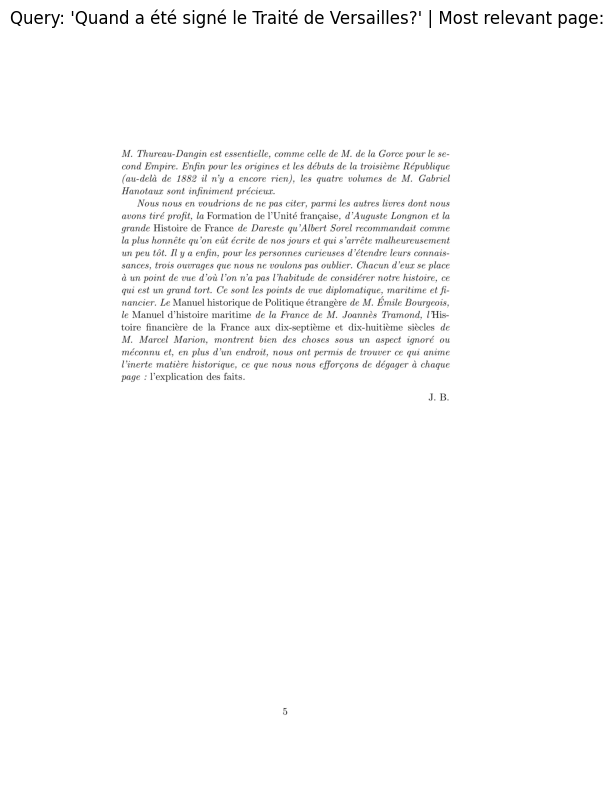

In [72]:
import fitz

# Open PDF and load target page
# pdf_path = "human-nutrition-text.pdf" # requires PDF to be downloaded
pdf_path = "Histoire-de-France-Jacques-Bainville.pdf"
doc = fitz.open(pdf_path)
#page = doc.load_page(5 + 41) # number of page (our doc starts page numbers on page 41)
page = doc.load_page(4)

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()